In [10]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd

In [12]:
import tensorflow
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(1)
seed(1)

TypeError: 'type' object is not subscriptable

In [7]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# heart_rate.csv may have more rows in reality, but we are only loading previewing the first 1000 rows
df1 = pd.read_csv('heart_rate.csv')
df1 = pd.DataFrame(df1)
nRow, nCol = df1.shape
print(f'Number of Rows: {nRow}\nNumber of Columns: {nCol}')

df1.head()

Number of Rows: 1800
Number of Columns: 4


,T1,T2,T3,T4
0,84.2697,91.4634,60.4839,59.2885
1,84.2697,91.4634,60.4839,59.2885
2,84.0619,91.1834,60.4606,59.2885
3,85.6542,91.8788,60.3391,58.8973
4,87.2093,91.1772,60.0762,58.4359


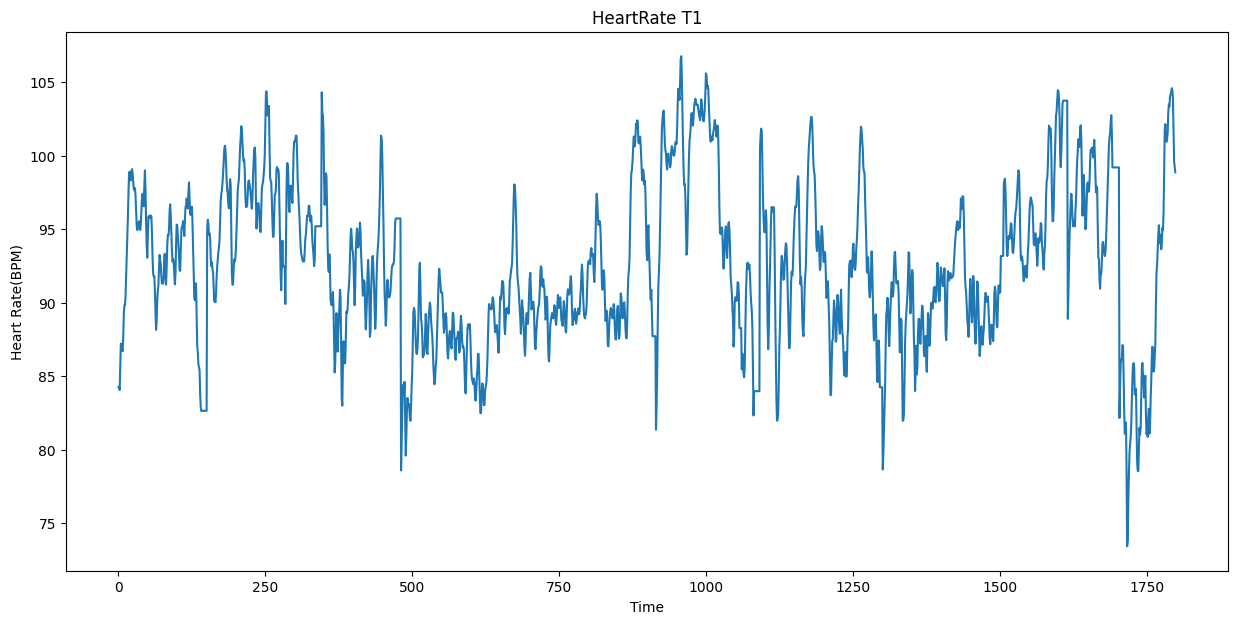

In [8]:
plt.figure(figsize=(15, 7))
plt.title("HeartRate T1")
plt.xlabel("Time")
plt.ylabel("Heart Rate(BPM)")
plt.plot(df1['T1'])
plt.show()

In [9]:
split = int(len(df1) * 0.9)
split

1620

In [10]:
data = df1['T1']
train = pd.Series(data[:split], name='heartrate')
train = pd.DataFrame(train)
test = pd.Series(data[split:], name='heartrate')
test = pd.DataFrame(test)

len(train), len(test)

(1620, 180)

In [11]:
train.head()

,heartrate
0,84.2697
1,84.2697
2,84.0619
3,85.6542
4,87.2093


In [12]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()

    #Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1): # window timestamp shift
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]

    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]

    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [13]:
train_gp = train.copy()
train_gp.columns = ['heartrate']

window = 29  # 29 shifts (randomly decided)
lag = len(test)
series = series_to_supervised(train_gp, window=window, lag=lag)

series

,heartrate(t-29),heartrate(t-28),heartrate(t-27),heartrate(t-26),heartrate(t-25),heartrate(t-24),heartrate(t-23),heartrate(t-22),heartrate(t-21),heartrate(t-20),...,heartrate(t-8),heartrate(t-7),heartrate(t-6),heartrate(t-5),heartrate(t-4),heartrate(t-3),heartrate(t-2),heartrate(t-1),heartrate(t),heartrate(t+180)
29,84.2697,84.2697,84.0619,85.6542,87.2093,87.1246,86.8726,86.7052,87.5899,89.1475,...,98.3075,98.8313,99.0789,98.8157,98.2998,97.7311,97.6471,97.7922,97.2974,101.9960
30,84.2697,84.0619,85.6542,87.2093,87.1246,86.8726,86.7052,87.5899,89.1475,89.8204,...,98.8313,99.0789,98.8157,98.2998,97.7311,97.6471,97.7922,97.2974,96.2042,101.7520
31,84.0619,85.6542,87.2093,87.1246,86.8726,86.7052,87.5899,89.1475,89.8204,89.8204,...,99.0789,98.8157,98.2998,97.7311,97.6471,97.7922,97.2974,96.2042,95.2318,100.9570
32,85.6542,87.2093,87.1246,86.8726,86.7052,87.5899,89.1475,89.8204,89.8204,90.4375,...,98.8157,98.2998,97.7311,97.6471,97.7922,97.2974,96.2042,95.2318,94.9367,100.0260
33,87.2093,87.1246,86.8726,86.7052,87.5899,89.1475,89.8204,89.8204,90.4375,91.7605,...,98.2998,97.7311,97.6471,97.7922,97.2974,96.2042,95.2318,94.9367,95.0867,99.6107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,92.3337,90.5921,87.9201,87.4514,88.6984,91.0847,92.1454,91.5808,91.5105,91.7911,...,95.3963,95.5366,94.9357,95.0073,95.4717,95.0670,95.8198,97.0809,96.7027,103.7340
1436,90.5921,87.9201,87.4514,88.6984,91.0847,92.1454,91.5808,91.5105,91.7911,92.0245,...,95.5366,94.9357,95.0073,95.4717,95.0670,95.8198,97.0809,96.7027,96.3891,88.9034
1437,87.9201,87.4514,88.6984,91.0847,92.1454,91.5808,91.5105,91.7911,92.0245,91.8674,...,94.9357,95.0073,95.4717,95.0670,95.8198,97.0809,96.7027,96.3891,97.2328,90.5565
1438,87.4514,88.6984,91.0847,92.1454,91.5808,91.5105,91.7911,92.0245,91.8674,91.6564,...,95.0073,95.4717,95.0670,95.8198,97.0809,96.7027,96.3891,97.2328,97.2177,92.8345


In [14]:
train_gp[360:370]

,heartrate
360,92.3664
361,90.1977
362,89.9113
363,89.8204
364,90.3604
365,90.7207
366,89.6519
367,87.2386
368,85.2571
369,85.9714


In [15]:
labels_col = 'heartrate(t+%d)' % lag
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values,
                                                     test_size=0.2, random_state=0)

print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)

Train set shape (1128, 30)
Validation set shape (283, 30)


In [16]:
epochs = 100
batch = 256
lr = 0.0001
adam = optimizers.Adam(lr)

MLP

In [17]:
# model architecture
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu',
                   input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam, metrics=['accuracy'])

# Train
mlp_history = model_mlp.fit(X_train.values, Y_train,
                           validation_data=(X_valid.values, Y_valid),
                           epochs=epochs,
                           verbose=2)

Epoch 1/100
36/36 - 1s - 39ms/step - accuracy: 0.0000e+00 - loss: 4362.3994 - val_accuracy: 0.0000e+00 - val_loss: 1351.8429
Epoch 2/100
36/36 - 0s - 3ms/step - accuracy: 0.0000e+00 - loss: 471.4641 - val_accuracy: 0.0000e+00 - val_loss: 73.5665
Epoch 3/100
36/36 - 0s - 4ms/step - accuracy: 0.0000e+00 - loss: 54.0625 - val_accuracy: 0.0000e+00 - val_loss: 47.0596
Epoch 4/100
36/36 - 0s - 3ms/step - accuracy: 0.0000e+00 - loss: 50.8593 - val_accuracy: 0.0000e+00 - val_loss: 46.6989
Epoch 5/100
36/36 - 0s - 4ms/step - accuracy: 0.0000e+00 - loss: 50.5929 - val_accuracy: 0.0000e+00 - val_loss: 46.6922
Epoch 6/100
36/36 - 0s - 3ms/step - accuracy: 0.0000e+00 - loss: 50.5638 - val_accuracy: 0.0000e+00 - val_loss: 46.6672
Epoch 7/100
36/36 - 0s - 4ms/step - accuracy: 0.0000e+00 - loss: 50.5442 - val_accuracy: 0.0000e+00 - val_loss: 46.6507
Epoch 8/100
36/36 - 0s - 3ms/step - accuracy: 0.0000e+00 - loss: 50.5229 - val_accuracy: 0.0000e+00 - val_loss: 46.6351
Epoch 9/100
36/36 - 0s - 3ms/step 

In [18]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)

Y_train_ = pd.DataFrame({
    'y_true': Y_train,
    'y_pred': mlp_train_pred.reshape(mlp_train_pred.shape[0],)
}).set_index(X_train.index).sort_index()
Y_train_ = pd.merge(Y_train_, train_gp,
                   left_index=True, right_index=True,
                   how='left')

Y_valid_ = pd.DataFrame({
    'y_true': Y_valid,
    'y_pred': mlp_valid_pred.reshape(mlp_valid_pred.shape[0],)
}).set_index(X_valid.index).sort_index()
Y_valid_ = pd.merge(Y_valid_, train_gp,
                 left_index=True, right_index=True,
                 how='left')

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [19]:
from sklearn import metrics

def scoring(y_true, y_pred):
    r2 = round(metrics.r2_score(y_true, y_pred) * 100, 3)
    #  mae = round(metrics.mean_absolute_error(y_true, y_pred), 3)
    corr = round(np.corrcoef(y_true, y_pred)[0, 1], 3)
    mape = round(
        metrics.mean_absolute_percentage_error(y_true, y_pred) * 100, 3
    )
    rmse = round(metrics.mean_squared_error(y_true, y_pred, squared=False), 3)

    df = pd.DataFrame({
        'R2': r2,
        'Corr': corr,
        'RMSE': rmse,
        'MAPE': mape
    }, index=[0])

    return df

In [20]:
scoring(Y_train_.y_true, Y_train_.y_pred)

,R2,Corr,RMSE,MAPE
0,-77.761,-0.096,6.998,6.3


In [21]:
scoring(Y_valid_.y_true, Y_valid_.y_pred)

,R2,Corr,RMSE,MAPE
0,-65.443,0.029,6.729,6.099


In [22]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

def MinMax(y_true, y_pred, m="min"):
    if(m == "min"):
        return min(min(y_true), min(y_pred)) - 2
    else:
        return max(max(y_true), max(y_pred)) + 2

def myGraph(temp, title):
    fig, axs = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'width_ratios': [2.5, 1]})
    axs[0].plot(temp.index, temp.y_true, label="Original")
    axs[0].plot(temp.index, temp.y_pred, label="Predicted")
    axs[0].legend(loc='upper right')
    axs[0].title.set_text(title)
    axs[0].set_xlabel("Time (index)")
    axs[0].set_ylabel("Heart Rate (BPM)")

    axs[1].plot(temp.y_true, temp.y_pred, '.')

    plt.xlim(MinMax(temp.y_true, temp.y_pred), MinMax(temp.y_true, temp.y_pred, "max"))
    plt.ylim(MinMax(temp.y_true, temp.y_pred), MinMax(temp.y_true, temp.y_pred, "max"))

    abline(1, 0)
    plt.title(title)
    plt.xlabel("Original")
    plt.ylabel("Predicted")

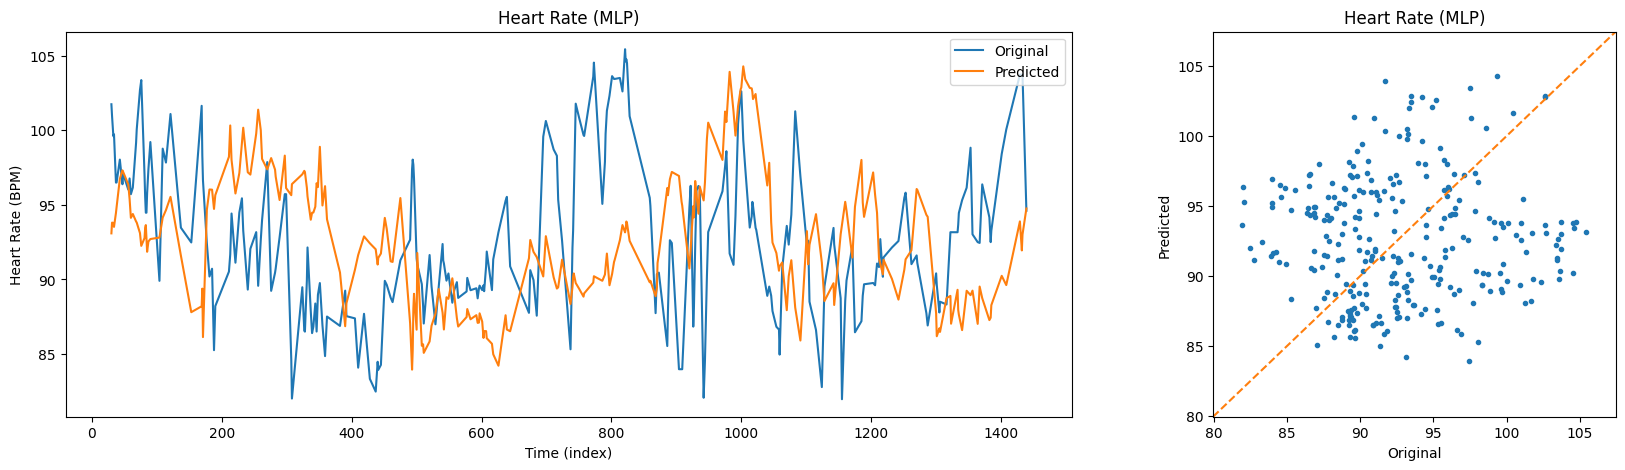

In [23]:
myGraph(Y_valid_, 'Heart Rate (MLP)')

CNN

In [24]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))

print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1128, 30, 1)
Validation set shape (283, 30, 1)


In [25]:
import tensorflow
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu',
                    input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=tensorflow.keras.optimizers.Adam())

cnn_history = model_cnn.fit(X_train_series, Y_train,
                           validation_data=(X_valid_series, Y_valid),
                           epochs=epochs, verbose=2)

Epoch 1/100
36/36 - 2s - 55ms/step - loss: 766.2773 - val_loss: 75.1638
Epoch 2/100
36/36 - 0s - 10ms/step - loss: 59.0515 - val_loss: 45.2637
Epoch 3/100
36/36 - 0s - 6ms/step - loss: 50.1066 - val_loss: 44.9739
Epoch 4/100
36/36 - 0s - 8ms/step - loss: 50.1353 - val_loss: 44.9633
Epoch 5/100
36/36 - 0s - 9ms/step - loss: 50.1585 - val_loss: 44.9891
Epoch 6/100
36/36 - 0s - 8ms/step - loss: 50.2079 - val_loss: 44.8169
Epoch 7/100
36/36 - 0s - 9ms/step - loss: 50.0387 - val_loss: 44.8101
Epoch 8/100
36/36 - 0s - 8ms/step - loss: 50.0201 - val_loss: 44.8428
Epoch 9/100
36/36 - 0s - 5ms/step - loss: 49.9379 - val_loss: 44.9199
Epoch 10/100
36/36 - 0s - 8ms/step - loss: 49.8928 - val_loss: 45.0131
Epoch 11/100
36/36 - 0s - 4ms/step - loss: 49.8620 - val_loss: 45.0808
Epoch 12/100
36/36 - 0s - 4ms/step - loss: 49.8618 - val_loss: 45.1479
Epoch 13/100
36/36 - 0s - 4ms/step - loss: 49.8997 - val_loss: 45.2667
Epoch 14/100
36/36 - 0s - 5ms/step - loss: 49.9202 - val_loss: 45.4323
Epoch 15/100

In [26]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)

Y_train_ = pd.DataFrame({
    'y_true': Y_train,
    'y_pred': cnn_train_pred.reshape(cnn_train_pred.shape[0],)
}).set_index(X_train.index).sort_index()
Y_train_ = pd.merge(Y_train_, train_gp,
                   left_index=True, right_index=True,
                   how='left')

Y_valid_ = pd.DataFrame({
    'y_true': Y_valid,
    'y_pred': cnn_valid_pred.reshape(cnn_valid_pred.shape[0],)
}).set_index(X_valid.index).sort_index()
Y_valid_ = pd.merge(Y_valid_, train_gp,
                 left_index=True, right_index=True,
                 how='left')

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [27]:
scoring(Y_train_.y_true, Y_train_.y_pred)

,R2,Corr,RMSE,MAPE
0,-69.76,-0.116,6.839,6.112


In [28]:
scoring(Y_valid_.y_true, Y_valid_.y_pred)

,R2,Corr,RMSE,MAPE
0,-59.388,-0.001,6.605,5.901


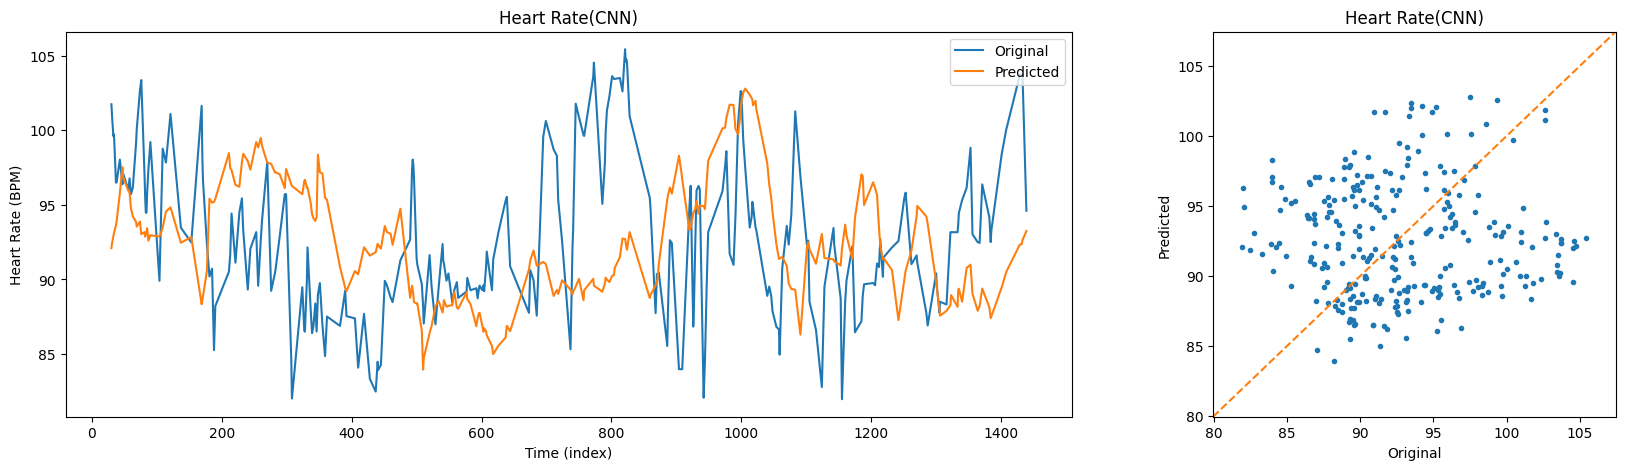

In [29]:
myGraph(Y_valid_, "Heart Rate(CNN)")

In [30]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=tensorflow.keras.optimizers.Adam(),metrics=['accuracy'])

lstm_history = model_lstm.fit(X_train_series, Y_train,
                              validation_data=(X_valid_series, Y_valid),
                              epochs=50,
                              verbose=2)

Epoch 1/50
36/36 - 3s - 89ms/step - accuracy: 0.0000e+00 - loss: 3088.1099 - val_accuracy: 0.0000e+00 - val_loss: 728.8077
Epoch 2/50
36/36 - 1s - 28ms/step - accuracy: 0.0000e+00 - loss: 293.5303 - val_accuracy: 0.0000e+00 - val_loss: 58.1728
Epoch 3/50
36/36 - 1s - 17ms/step - accuracy: 0.0000e+00 - loss: 479.1584 - val_accuracy: 0.0000e+00 - val_loss: 149.7388
Epoch 4/50
36/36 - 1s - 15ms/step - accuracy: 0.0000e+00 - loss: 1015.5975 - val_accuracy: 0.0000e+00 - val_loss: 617.8787
Epoch 5/50
36/36 - 1s - 15ms/step - accuracy: 0.0000e+00 - loss: 282.6764 - val_accuracy: 0.0000e+00 - val_loss: 75.7865
Epoch 6/50
36/36 - 1s - 15ms/step - accuracy: 0.0000e+00 - loss: 44.6881 - val_accuracy: 0.0000e+00 - val_loss: 34.3348
Epoch 7/50
36/36 - 1s - 14ms/step - accuracy: 0.0000e+00 - loss: 35.4688 - val_accuracy: 0.0000e+00 - val_loss: 31.8413
Epoch 8/50
36/36 - 1s - 17ms/step - accuracy: 0.0000e+00 - loss: 34.5587 - val_accuracy: 0.0000e+00 - val_loss: 31.0706
Epoch 9/50
36/36 - 1s - 17ms/s

In [31]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_lstm.predict(X_valid_series)

Y_train_ = pd.DataFrame({
    'y_true': Y_train,
    'y_pred': lstm_train_pred.reshape(lstm_train_pred.shape[0],)
}).set_index(X_train.index).sort_index()
Y_train_ = pd.merge(Y_train_, train_gp,
                   left_index=True, right_index=True,
                   how='left')

Y_valid_ = pd.DataFrame({
    'y_true': Y_valid,
    'y_pred': lstm_valid_pred.reshape(lstm_valid_pred.shape[0],)
}).set_index(X_valid.index).sort_index()
Y_valid_ = pd.merge(Y_valid_, train_gp,
                 left_index=True, right_index=True,
                 how='left')

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [32]:
scoring(Y_train_.y_true, Y_train_.y_pred)

,R2,Corr,RMSE,MAPE
0,0.16,0.122,5.245,4.567


In [33]:
scoring(Y_valid_.y_true, Y_valid_.y_pred)

,R2,Corr,RMSE,MAPE
0,-6.745,0.002,5.405,4.613


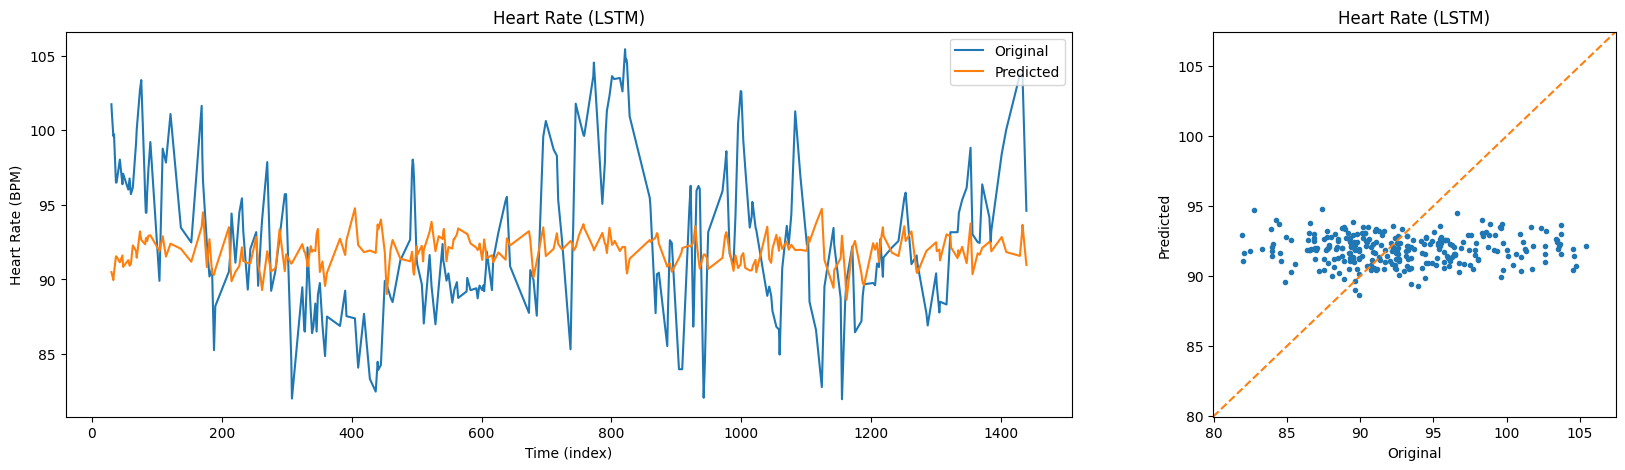

In [34]:
myGraph(Y_valid_, 'Heart Rate (LSTM)')

CNN+LSTM

In [35]:
subsequences = 2
timesteps = X_train_series.shape[1] // subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))

print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (1128, 2, 15, 1)
Validation set shape (283, 2, 15, 1)


In [36]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(
    Conv1D(filters=64, kernel_size=1,activation='relu'),
    input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])
))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=tensorflow.keras.optimizers.Adam())

cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train,
                                     validation_data=(X_valid_series_sub, Y_valid),
                                     epochs=epochs, verbose=2)

Epoch 1/100
36/36 - 4s - 118ms/step - loss: 816.7418 - val_loss: 58.4072
Epoch 2/100
36/36 - 1s - 16ms/step - loss: 53.0251 - val_loss: 44.5857
Epoch 3/100
36/36 - 0s - 9ms/step - loss: 49.9068 - val_loss: 44.6122
Epoch 4/100
36/36 - 1s - 17ms/step - loss: 50.1808 - val_loss: 44.5879
Epoch 5/100
36/36 - 0s - 9ms/step - loss: 50.2676 - val_loss: 44.6285
Epoch 6/100
36/36 - 0s - 9ms/step - loss: 50.1810 - val_loss: 44.8884
Epoch 7/100
36/36 - 0s - 10ms/step - loss: 50.1542 - val_loss: 45.0641
Epoch 8/100
36/36 - 1s - 17ms/step - loss: 50.2168 - val_loss: 45.2489
Epoch 9/100
36/36 - 1s - 17ms/step - loss: 50.3186 - val_loss: 45.4833
Epoch 10/100
36/36 - 0s - 9ms/step - loss: 50.4451 - val_loss: 45.7906
Epoch 11/100
36/36 - 1s - 17ms/step - loss: 50.5879 - val_loss: 46.1848
Epoch 12/100
36/36 - 1s - 18ms/step - loss: 50.7369 - val_loss: 46.6558
Epoch 13/100
36/36 - 1s - 17ms/step - loss: 50.8786 - val_loss: 47.1546
Epoch 14/100
36/36 - 0s - 9ms/step - loss: 50.9980 - val_loss: 47.5925
Epoc

In [37]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)

Y_train_ = pd.DataFrame({
    'y_true': Y_train,
    'y_pred': cnn_lstm_train_pred.reshape(cnn_lstm_train_pred.shape[0],)
}).set_index(X_train.index).sort_index()
Y_train_ = pd.merge(Y_train_, train_gp,
                   left_index=True, right_index=True,
                   how='left')

Y_valid_ = pd.DataFrame({
    'y_true': Y_valid,
    'y_pred': cnn_lstm_valid_pred.reshape(cnn_lstm_valid_pred.shape[0],)
}).set_index(X_valid.index).sort_index()
Y_valid_ = pd.merge(Y_valid_, train_gp,
                   left_index=True, right_index=True,
                   how='left')

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [38]:
scoring(Y_train_.y_true, Y_train_.y_pred)

,R2,Corr,RMSE,MAPE
0,-73.867,-0.124,6.921,6.194


In [39]:
scoring(Y_valid_.y_true, Y_valid_.y_pred)

,R2,Corr,RMSE,MAPE
0,-60.416,0.012,6.626,5.965


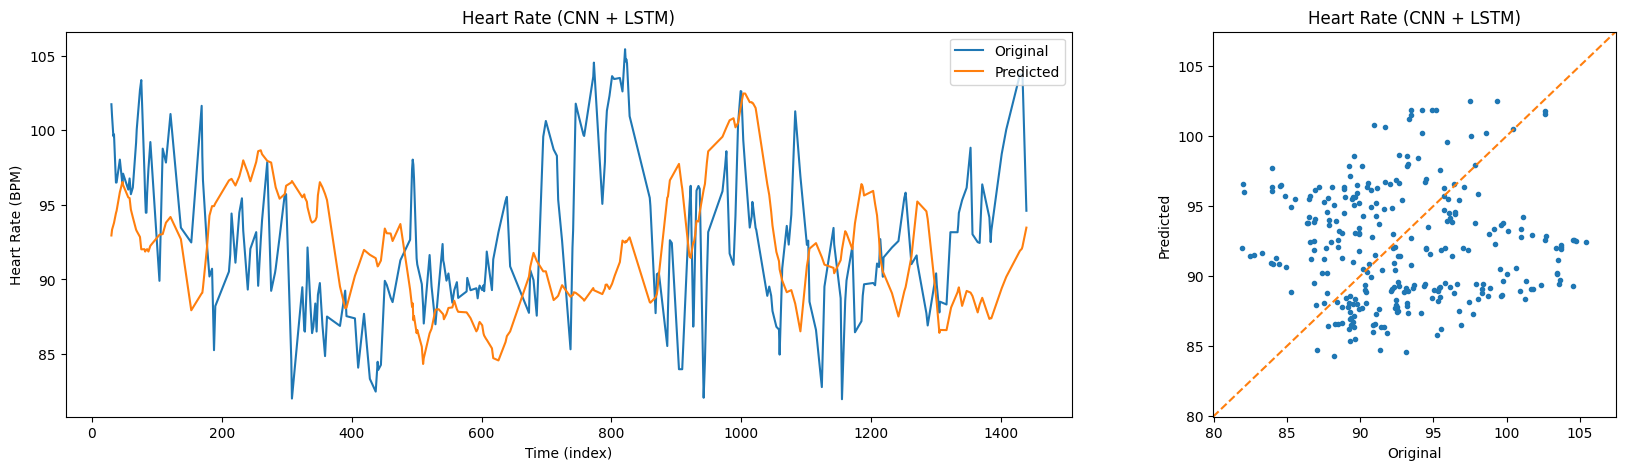

In [40]:
myGraph(Y_valid_, 'Heart Rate (CNN + LSTM)')

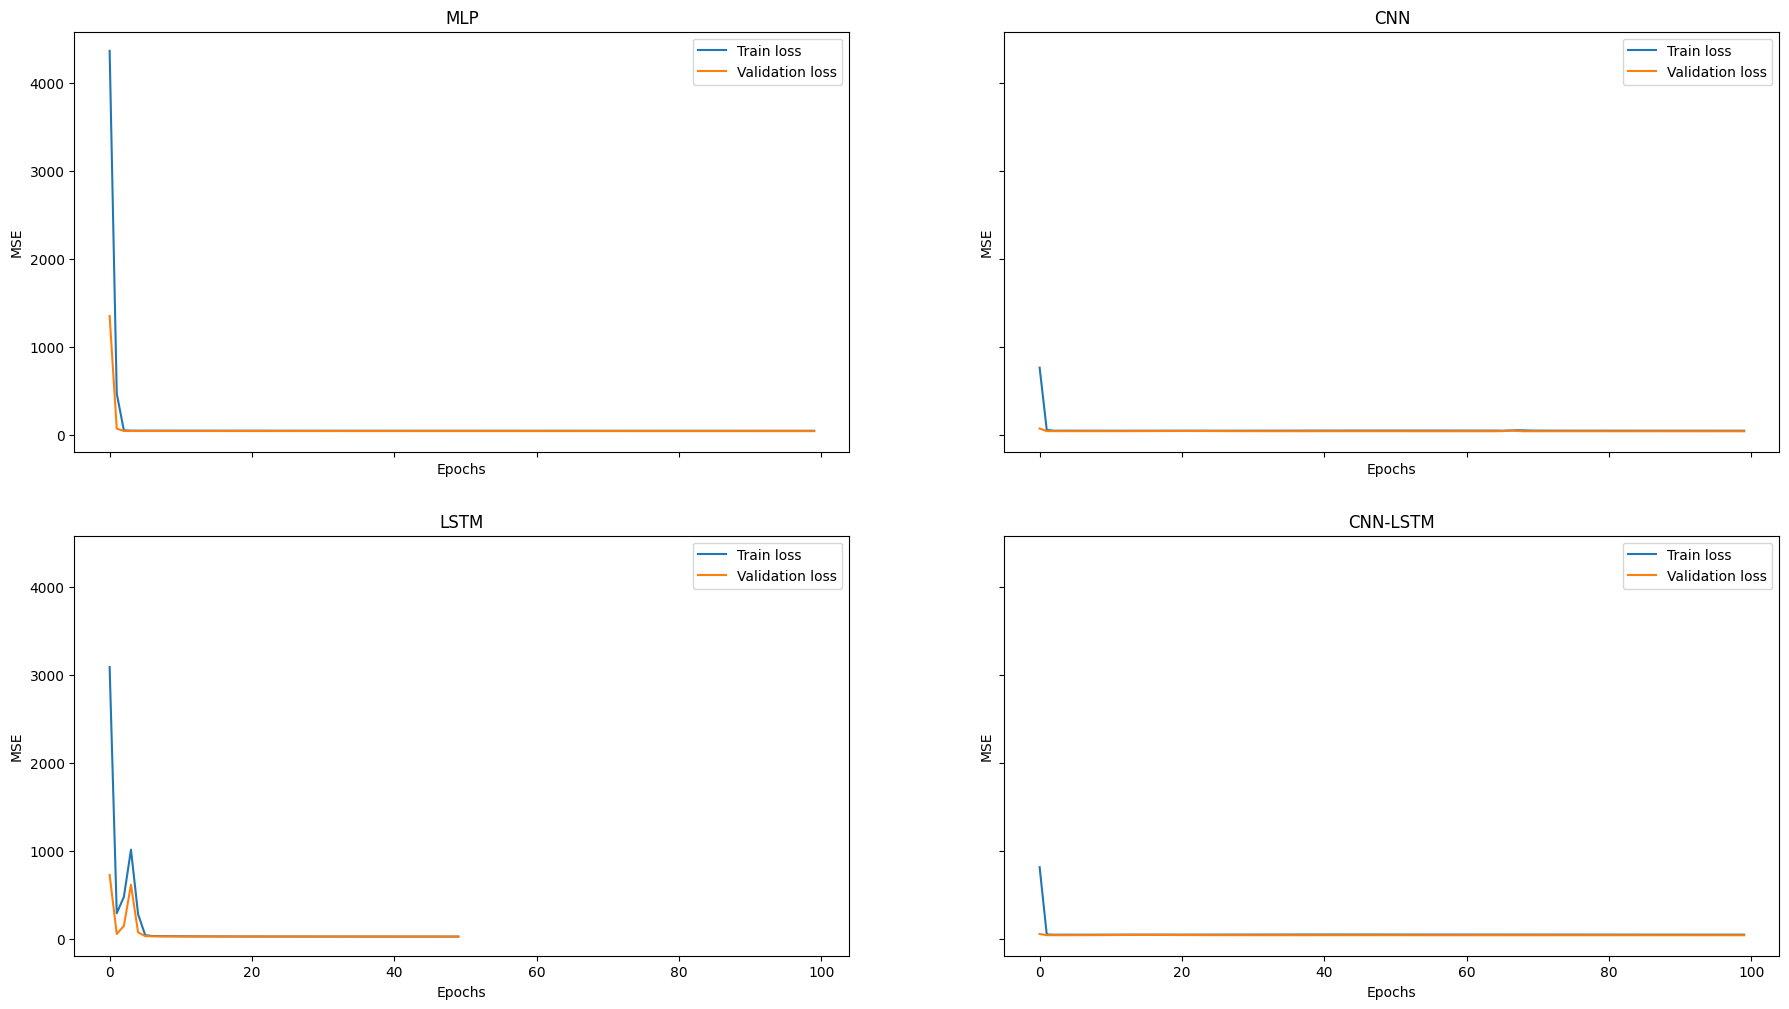

In [41]:
fix, axes = plt.subplots(
    2, 2, sharex=True, sharey=True, figsize=(22, 12))
ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

Train set shape: (1128, 30, 1, 1)
Validation set shape: (283, 30, 1, 1)
Epoch 1/100
36/36 - 2s - 67ms/step - loss: 1093.5493 - val_loss: 52.0222
Epoch 2/100
36/36 - 0s - 13ms/step - loss: 198.7911 - val_loss: 46.5619
Epoch 3/100
36/36 - 1s - 16ms/step - loss: 187.3227 - val_loss: 55.4586
Epoch 4/100
36/36 - 0s - 10ms/step - loss: 185.1976 - val_loss: 44.6135
Epoch 5/100
36/36 - 1s - 16ms/step - loss: 186.3358 - val_loss: 46.3252
Epoch 6/100
36/36 - 0s - 10ms/step - loss: 183.6680 - val_loss: 44.5152
Epoch 7/100
36/36 - 0s - 10ms/step - loss: 170.3808 - val_loss: 87.0091
Epoch 8/100
36/36 - 1s - 16ms/step - loss: 187.3452 - val_loss: 48.4205
Epoch 9/100
36/36 - 1s - 17ms/step - loss: 183.4151 - val_loss: 44.6579
Epoch 10/100
36/36 - 1s - 19ms/step - loss: 170.0659 - val_loss: 47.7824
Epoch 11/100
36/36 - 1s - 16ms/step - loss: 159.8787 - val_loss: 49.8920
Epoch 12/100
36/36 - 0s - 13ms/step - loss: 166.8148 - val_loss: 45.7242
Epoch 13/100
36/36 - 1s - 18ms/step - loss: 157.4649 - val_l

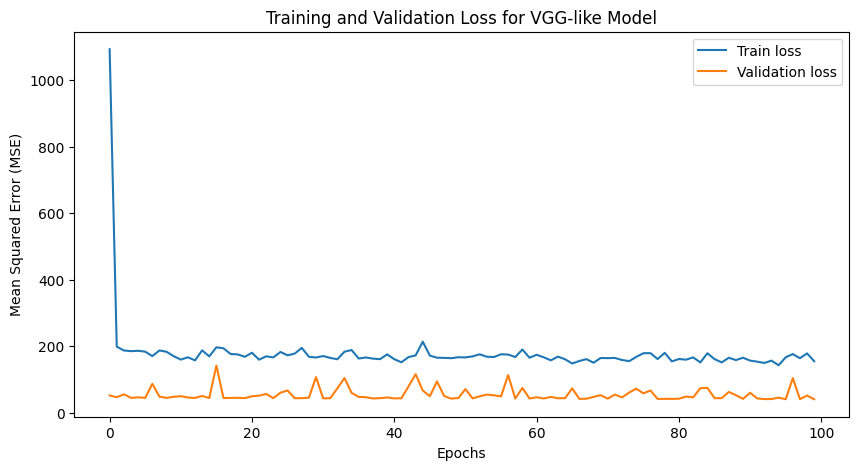

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,R2,Corr,RMSE,MAPE
0,-48.367,0.005,6.373,5.67


In [42]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# Assuming X_train_series, Y_train, X_valid_series, and Y_valid are loaded and ready
# Original shape of X_train_series: (1128, 30, 1)
# Original shape of X_valid_series: (283, 30, 1)

# Reshape the data for Conv2D input
X_train_2d = X_train_series.reshape((X_train_series.shape[0], 30, 1, 1))
X_valid_2d = X_valid_series.reshape((X_valid_series.shape[0], 30, 1, 1))

print('Train set shape:', X_train_2d.shape)  # Should be (1128, 30, 1, 1)
print('Validation set shape:', X_valid_2d.shape)  # Should be (283, 30, 1, 1)

# Define a simplified VGG-like model
model_vgg = Sequential()

# Convolutional block 1
model_vgg.add(Conv2D(32, (3, 1), activation='relu', padding='same', input_shape=(30, 1, 1)))
model_vgg.add(Conv2D(32, (3, 1), activation='relu', padding='same'))
model_vgg.add(MaxPooling2D((2, 1)))  # Pool only along the time dimension

# Convolutional block 2
model_vgg.add(Conv2D(64, (3, 1), activation='relu', padding='same'))
model_vgg.add(Conv2D(64, (3, 1), activation='relu', padding='same'))
model_vgg.add(MaxPooling2D((2, 1)))  # Pool only along the time dimension

# Flatten and Dense layers
model_vgg.add(Flatten())
model_vgg.add(Dense(256, activation='relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(1))  # Output layer for regression

# Compile the model
model_vgg.compile(optimizer='adam', loss='mse')

# Set training parameters
epochs = 100  # Adjust this as needed for your dataset

# Train the model
vgg_history = model_vgg.fit(X_train_2d, Y_train,
                            validation_data=(X_valid_2d, Y_valid),
                            epochs=epochs, verbose=2)

# Evaluate and plot training history
plt.figure(figsize=(10, 5))
plt.plot(vgg_history.history['loss'], label='Train loss')
plt.plot(vgg_history.history['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss for VGG-like Model')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()

# Predict on the training and validation sets
vgg_train_pred = model_vgg.predict(X_train_2d)
vgg_valid_pred = model_vgg.predict(X_valid_2d)

Y_train_vgg = pd.DataFrame({
    'y_true': Y_train,
    'y_pred': vgg_train_pred.reshape(vgg_train_pred.shape[0],)
}).set_index(X_train.index).sort_index()
Y_train_vgg = pd.merge(Y_train_vgg, train_gp,
                   left_index=True, right_index=True,
                   how='left')

Y_valid_vgg = pd.DataFrame({
    'y_true': Y_valid,
    'y_pred': vgg_valid_pred.reshape(vgg_valid_pred.shape[0],)
}).set_index(X_valid.index).sort_index()
Y_valid_vgg = pd.merge(Y_valid_vgg, train_gp,
                   left_index=True, right_index=True,
                   how='left')

# Scoring function
def scoring(y_true, y_pred):
    r2 = round(metrics.r2_score(y_true, y_pred) * 100, 3)
    #  mae = round(metrics.mean_absolute_error(y_true, y_pred), 3)
    corr = round(np.corrcoef(y_true, y_pred)[0, 1], 3)
    mape = round(
        metrics.mean_absolute_percentage_error(y_true, y_pred) * 100, 3
    )
    rmse = round(metrics.mean_squared_error(y_true, y_pred, squared=False), 3)

    df = pd.DataFrame({
        'R2': r2,
        'Corr': corr,
        'RMSE': rmse,
        'MAPE': mape
    }, index=[0])

    return df


# Calculate scores
scoring(Y_train_vgg.y_true, Y_train_vgg.y_pred)
scoring(Y_valid_vgg.y_true, Y_valid_vgg.y_pred)

# (Optional) Custom graph plotting function
# Define your custom graph function here if required


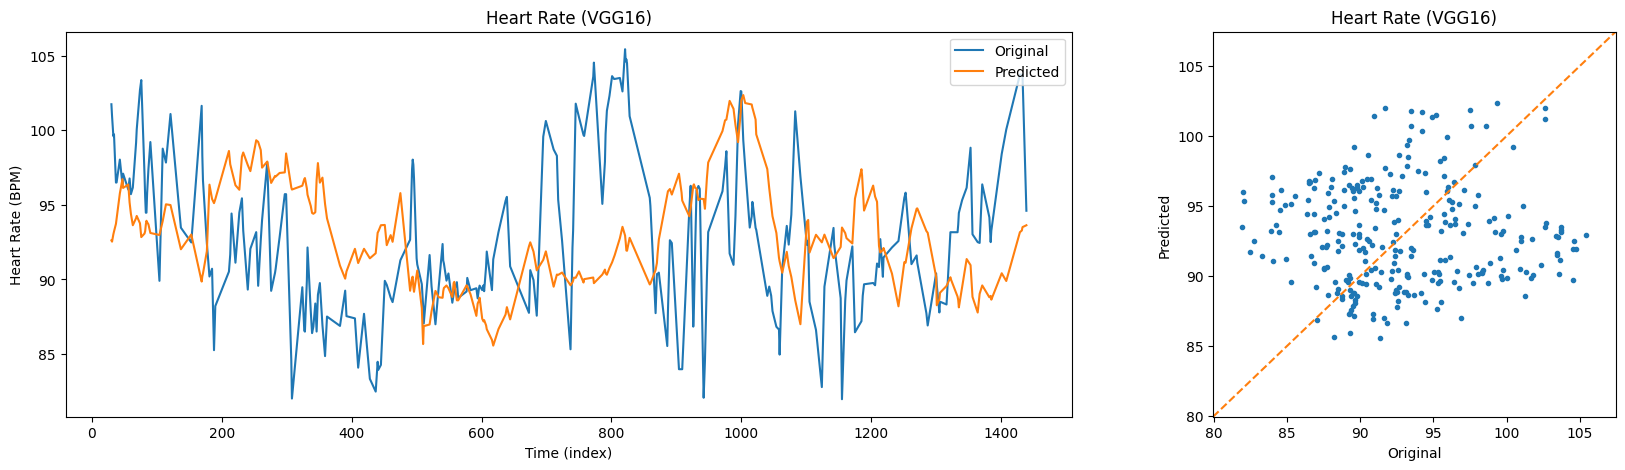

In [43]:
myGraph(Y_valid_vgg, 'Heart Rate (VGG16)')

Train set shape: (1128, 32, 32, 3)
Validation set shape: (283, 32, 32, 3)
Epoch 1/100
36/36 - 30s - 841ms/step - loss: 1986.6609 - val_loss: 7417.6255
Epoch 2/100
36/36 - 20s - 543ms/step - loss: 180.7291 - val_loss: 6026.3027
Epoch 3/100
36/36 - 20s - 569ms/step - loss: 144.8834 - val_loss: 4288.5488
Epoch 4/100
36/36 - 20s - 567ms/step - loss: 134.2017 - val_loss: 2814.6106
Epoch 5/100
36/36 - 11s - 318ms/step - loss: 120.5220 - val_loss: 1530.4285
Epoch 6/100
36/36 - 11s - 319ms/step - loss: 133.9115 - val_loss: 823.6013
Epoch 7/100
36/36 - 21s - 587ms/step - loss: 113.6898 - val_loss: 389.1768
Epoch 8/100
36/36 - 12s - 336ms/step - loss: 109.0764 - val_loss: 182.5228
Epoch 9/100
36/36 - 21s - 579ms/step - loss: 112.0699 - val_loss: 131.0239
Epoch 10/100
36/36 - 20s - 558ms/step - loss: 102.4163 - val_loss: 50.6505
Epoch 11/100
36/36 - 23s - 627ms/step - loss: 117.4921 - val_loss: 45.3076
Epoch 12/100
36/36 - 18s - 507ms/step - loss: 114.1707 - val_loss: 53.9389
Epoch 13/100
36/36 -

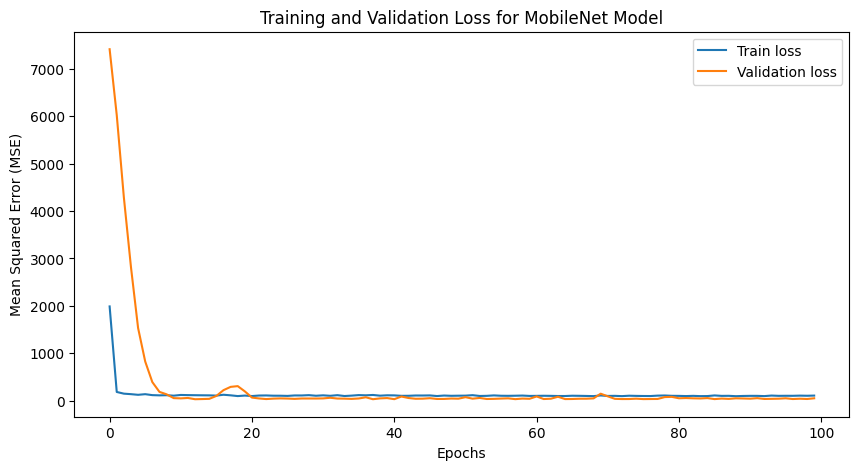

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Training Scores:
        R2   Corr   RMSE   MAPE
0 -79.144 -0.204  5.576  5.914
Validation Scores:
        R2   Corr   RMSE   MAPE
0 -72.289 -0.124  5.519  5.824


In [44]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# Assuming X_train_series, Y_train, X_valid_series, and Y_valid are loaded and ready
# Original shape of X_train_series: (1128, 30, 1)
# Original shape of X_valid_series: (283, 30, 1)

# Resize the input data to (32, 32, 3)
def resize_data(data):
    resized_data = np.zeros((data.shape[0], 32, 32, 3))
    for i in range(data.shape[0]):
        # Assuming the data is stored as grayscale (30, 1)
        # Expand dimensions to 3 channels
        img = np.zeros((32, 32, 3))
        img[:30, :1, 0] = data[i]  # Copy data into the first channel
        img[:30, :1, 1] = data[i]  # Copy data into the second channel
        img[:30, :1, 2] = data[i]  # Copy data into the third channel
        resized_data[i] = img
    return resized_data

X_train_2d = resize_data(X_train_series)
X_valid_2d = resize_data(X_valid_series)

print('Train set shape:', X_train_2d.shape)  # Should be (1128, 32, 32, 3)
print('Validation set shape:', X_valid_2d.shape)  # Should be (283, 32, 32, 3)

# Define a MobileNet-like model
model_mobilenet = Sequential()

# Add the MobileNet model
model_mobilenet.add(MobileNet(weights=None, include_top=False, input_shape=(32, 32, 3)))

# Flatten and Dense layers
model_mobilenet.add(Flatten())
model_mobilenet.add(Dense(256, activation='relu'))
model_mobilenet.add(Dropout(0.5))
model_mobilenet.add(Dense(1))  # Output layer for regression

# Compile the model
model_mobilenet.compile(optimizer='adam', loss='mse')

# Set training parameters
epochs = 100  # Adjust this as needed for your dataset

# Train the model
mobilenet_history = model_mobilenet.fit(X_train_2d, Y_train,
                                         validation_data=(X_valid_2d, Y_valid),
                                         epochs=epochs, verbose=2)

# Evaluate and plot training history
plt.figure(figsize=(10, 5))
plt.plot(mobilenet_history.history['loss'], label='Train loss')
plt.plot(mobilenet_history.history['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss for MobileNet Model')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()

# Predict on the training and validation sets
mobilenet_train_pred = model_mobilenet.predict(X_train_2d)
mobilenet_valid_pred = model_mobilenet.predict(X_valid_2d)

# Create DataFrames for predictions
Y_train_mobilenet = pd.DataFrame({
    'y_true': Y_train,
    'y_pred': mobilenet_train_pred.reshape(mobilenet_train_pred.shape[0],)
}).set_index(X_train.index).sort_index()

Y_valid_mobilenet = pd.DataFrame({
    'y_true': Y_valid,
    'y_pred': mobilenet_valid_pred.reshape(mobilenet_valid_pred.shape[0],)
}).set_index(X_valid.index).sort_index()

# Scoring function
def scoring(y_true, y_pred):
    r2 = round(r2_score(y_true, y_pred) * 100, 3)
    corr = round(np.corrcoef(y_true, y_pred)[0, 1], 3)
    mape = round(
        np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 3
    )
    rmse = round(mean_absolute_error(y_true, y_pred), 3)  # Use RMSE if needed

    df = pd.DataFrame({
        'R2': r2,
        'Corr': corr,
        'RMSE': rmse,
        'MAPE': mape
    }, index=[0])

    return df

# Calculate scores
train_scores = scoring(Y_train_mobilenet.y_true, Y_train_mobilenet.y_pred)
valid_scores = scoring(Y_valid_mobilenet.y_true, Y_valid_mobilenet.y_pred)

# Display scores
print("Training Scores:\n", train_scores)
print("Validation Scores:\n", valid_scores)

# (Optional) Custom graph plotting function
# Define your custom graph function here if required


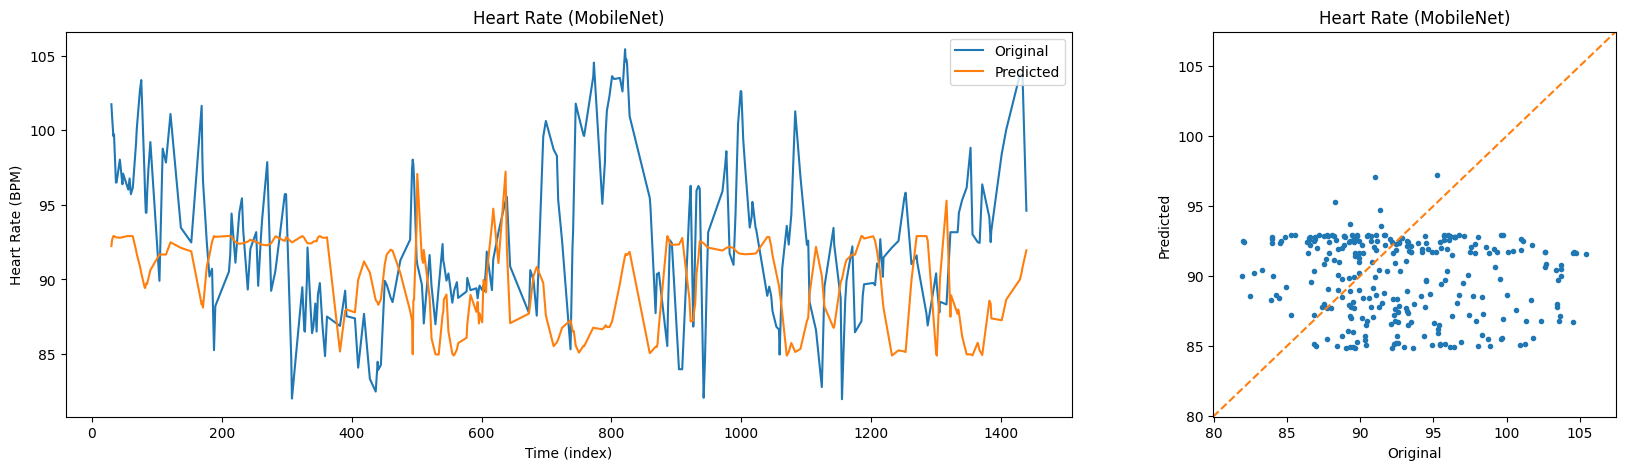

In [45]:
myGraph(Y_valid_mobilenet, 'Heart Rate (MobileNet)')

In [7]:
!pip install keras